In [61]:
import duckdb
import pandas as pd 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
con = duckdb.connect(r"C:/Users/jovan/Documents/CSE 6748 Practicum WITH DATA/financial_news.db", read_only=True)
# con.close()

Goal here is to find how VIX correlates with the data and price movements 
- by checking in the vix.sql, we see that they're correlated. moderate to high vix impacts the market greatly the next day 

Now need to 
- compute correlation between variables 
    - lets put some math behind this
- see how the sentiment correlates to price movements 
- see if sentiment matters when price is high

In [42]:
corr_df = con.execute("""
SELECT 
    v.vix_date, 
    v.vix_value, 
    CASE 
        WHEN v.vix_value < 15 THEN 'Low Volatility'
        WHEN v.vix_value BETWEEN 15 AND 25 THEN 'Moderate Volatility'
        WHEN v.vix_value BETWEEN 25 AND 30 THEN 'High Volatility'
        ELSE 'Extreme Volatility'
    END AS vix_category,
    e.trading_date,
    e.ticker,
    e.price_change_percentage,
    e.movement_type
FROM SP500.VIX_Index v
JOIN Headlines.extreme_price_movements e 
    ON e.trading_date = v.vix_date + INTERVAL '7 day'
ORDER BY v.vix_value DESC;
                      """).fetch_df()

corr_df.head()

,vix_date,vix_value,vix_category,trading_date,ticker,price_change_percentage,movement_type
0,2024-08-05,38.57,Extreme Volatility,2024-08-12,APPN,7.18,Surge
1,2024-08-05,38.57,Extreme Volatility,2024-08-12,BAX,-6.55,Drop
2,2024-08-05,38.57,Extreme Volatility,2024-08-12,IONQ,8.33,Surge
3,2024-08-05,38.57,Extreme Volatility,2024-08-12,FLNC,7.99,Surge
4,2024-08-05,38.57,Extreme Volatility,2024-08-12,SHLS,6.43,Surge


In [43]:
correlation, p_value = stats.pearsonr(corr_df['vix_value'], corr_df['price_change_percentage'])

# when we do itnerval 1 day, we get (np.float64(0.009074563488745468), np.float32(0.10172135))
# so basically 1 day is insignificant

# when we do interval 7 days, we get (np.float64(0.04920862773056811), np.float32(3.6324765e-24))
# small p value, so we reject the null hypothesis that there is no correlation between the two variables! 
# so we have correlation over the long term!

correlation, p_value

(np.float64(0.04920862773056811), np.float32(3.6324765e-24))

In [ ]:
# lets try spearmanr 
correlation, p_value = stats.spearmanr(corr_df['vix_value'], corr_df['price_change_percentage'])

# when we do interval 7 days, we get (np.float64(0.04496649049575841), np.float64(1.9348702859489684e-20))
# small p value, so we reject the null hypothesis that there is no correlation between the two variables!
# so we have correlation over the long term!

correlation, p_value

(np.float64(0.04496649049575841), np.float64(1.9348702859489684e-20))

In [52]:
high_vix_df = con.execute("""SELECT 
    v.vix_date, 
    v.vix_value, 
    e.trading_date,
    e.ticker,
    e.price_change_percentage,
    e.movement_type
FROM SP500.VIX_Index v
JOIN Headlines.extreme_price_movements e 
    ON e.trading_date = v.vix_date + INTERVAL '14 day'
WHERE v.vix_value > 15
ORDER BY v.vix_value DESC;
                        """).fetch_df() 

correlation, p_value = stats.pearsonr(high_vix_df['vix_value'], high_vix_df['price_change_percentage'])
print(f"Pearson correlation: {correlation}, p-value: {p_value}")

correlation, p_value = stats.spearmanr(high_vix_df['vix_value'], high_vix_df['price_change_percentage'])
print(f"Spearman correlation: {correlation}, p-value: {p_value}")

Pearson correlation: 0.028970190552421116, p-value: 6.567525900891269e-08
Spearman correlation: 0.023436367397636944, p-value: 1.24073413358565e-05


In [59]:
high_vix_df = con.execute(""" 
WITH vix_classified AS (
    SELECT 
        vix_date, 
        vix_value,
        CASE 
            WHEN vix_value < 15 THEN 'Low Volatility'
            WHEN vix_value BETWEEN 15 AND 25 THEN 'Moderate Volatility'
            WHEN vix_value BETWEEN 25 AND 30 THEN 'High Volatility'
            ELSE 'Extreme Volatility'
        END AS vix_category
    FROM SP500.VIX_Index
)
SELECT 
    v.vix_date,
    v.vix_value,
    v.vix_category,
    e.trading_date AS drop_date,
    e.ticker,
    e.movement_type,
    e.price_change_percentage,
    e.close_price,
    a.title_sentiment_score,
    a.title_sentiment_label,
    a.description_sentiment_score,
    a.description_sentiment_label
FROM vix_classified v
JOIN Headlines.extreme_price_movements e 
    ON e.trading_date = v.vix_date + INTERVAL '7 day'
LEFT JOIN Headlines.articles_extreme_drops a 
    ON e.trading_date = a.trading_date AND e.ticker = a.ticker
WHERE v.vix_value > 15
AND (a.title_sentiment_label = 'Negative' OR a.description_sentiment_label = 'Negative')    
ORDER BY v.vix_category DESC, v.vix_value DESC, e.price_change_percentage ASC;
                        """).fetch_df() 

correlation, p_value = stats.pearsonr(high_vix_df['vix_value'], high_vix_df['price_change_percentage'])
print(f"Pearson correlation: {correlation}, p-value: {p_value}")

correlation, p_value = stats.spearmanr(high_vix_df['vix_value'], high_vix_df['price_change_percentage'])
print(f"Spearman correlation: {correlation}, p-value: {p_value}")

Pearson correlation: 0.18383901758511456, p-value: 1.0743811479509963e-29
Spearman correlation: 0.16919537780422048, p-value: 2.4218138118240687e-25


# Correlation Analysis of VIX and Price Movements

Below is a table summarizing the Pearson and Spearman correlation values with different lags, VIX thresholds, and sentiment filters.

| Days Lag | VIX Threshold | Sentiment Filter | Pearson Correlation | Pearson p-value | Pearson Interpretation | Spearman Correlation | Spearman p-value | Spearman Interpretation |
|----------|--------------|------------------|----------------------|-----------------|------------------------|----------------------|------------------|------------------------|
| 7        | > 25         | None             | 0.0335               | 9.33e-05        | Weak positive, significant | 0.0039               | 0.6431           | No correlation |
| 7        | > 25         | Negative Only    | 0.0880               | 0.1874          | Weak positive, not significant | -0.0989              | 0.1383           | Weak negative, not significant |
| 7        | > 15         | Negative Only    | 0.1838               | 1.07e-29        | Moderate positive, highly significant | 0.1692               | 2.42e-25         | Moderate positive, highly significant |
| 14       | > 25         | None             | 0.0417               | 1.64e-06        | Weak positive, significant | 0.0513               | 3.47e-09         | Weak positive, significant |
| 14       | > 15         | None             | 0.0290               | 6.57e-08        | Weak positive, significant | 0.0234               | 1.24e-05         | Weak positive, significant |
| 14       | > 15         | Negative Only    | 0.0447               | 0.00996         | Weak positive, significant | 0.0993               | 9.58e-09         | Moderate positive, significant |
| 14       | > 25         | Negative Only    | -0.1323              | 0.3014          | Weak negative, not significant | -0.4430              | 2.77e-04         | Moderate negative, significant |


**Observations:**
- **Longer lags (14 days) improve correlation**, suggesting delayed market reactions.
- **Filtering for negative sentiment boosts correlation**, indicating that bad news affects price movements more.
- **Extreme VIX (>25) with negative sentiment reverses correlation**, possibly due to market overreaction leading to recoveries.
    - is this overcorrection? or maybe someone buying out after the drop?
    - could be that at high VIX the negative news are caked into the price!!!!!

So overall, the best predictive setup on just this correlation is 
- **VIX > 15-25**
    - targets moderate volatility 
- **7-day lag**
- **Incorporating Sentiment**
    - negative only ones showed stronger Spearman correlation, leading to a possible non-linear relationship?
---


In [18]:
sent_price_cor_df = con.execute("""
SELECT 
    a.trading_date,
    a.ticker,
    a.title_sentiment_score,
    a.title_sentiment_label,
    a.description_sentiment_score,
    a.description_sentiment_label,
    e.price_change_percentage,
    e.movement_type
FROM Headlines.articles_extreme_drops a
JOIN Headlines.extreme_price_movements e 
    ON a.trading_date = e.trading_date 
    AND a.ticker = e.ticker;
                        """).fetch_df()

sent_price_cor_df.head()

,trading_date,ticker,title_sentiment_score,title_sentiment_label,description_sentiment_score,description_sentiment_label,price_change_percentage,movement_type
0,2024-02-14,CBRE,0.999986,Neutral,0.999986,Neutral,8.53,Surge
1,2024-07-24,CBRE,0.999988,Neutral,0.999999,Neutral,9.29,Surge
2,2024-10-23,CBRE,0.677684,Neutral,0.999965,Positive,8.43,Surge
3,2024-04-16,APG,0.999833,Neutral,0.999857,Neutral,-5.24,Drop
4,2024-08-01,APG,0.999858,Neutral,0.999998,Neutral,-5.30,Drop


# Lets try to visualize the VIX and prices

In [74]:
df = con.execute("""
WITH vix_classified AS (
    SELECT 
        v.vix_date, 
        v.vix_value,
        CASE 
            WHEN v.vix_value < 15 THEN 'Low Volatility'
            WHEN v.vix_value BETWEEN 15 AND 25 THEN 'Moderate Volatility'
            WHEN v.vix_value BETWEEN 25 AND 30 THEN 'High Volatility'
            ELSE 'Extreme Volatility'
        END AS vix_category
    FROM SP500.VIX_Index v
),
joined AS (
    SELECT 
        v.vix_date,
        v.vix_value,
        v.vix_category,
        e.trading_date AS drop_date,
        e.ticker,
        e.movement_type,
        e.price_change_percentage,
        e.close_price,
        a.title_sentiment_score,
        a.title_sentiment_label,
        a.description_sentiment_score,
        a.description_sentiment_label
    FROM vix_classified v
    JOIN Headlines.extreme_price_movements e 
        ON e.trading_date = v.vix_date + INTERVAL '7 day'  -- Lagging by 7 days
    LEFT JOIN Headlines.articles_extreme_drops a 
        ON e.trading_date = a.trading_date AND e.ticker = a.ticker
)
SELECT 
    vix_date,
    vix_value,
    vix_category,
    drop_date,
    COUNT(CASE WHEN movement_type = 'Drop' THEN 1 END) AS num_drops,
    COUNT(CASE WHEN movement_type = 'Surge' THEN 1 END) AS num_surges
FROM joined
GROUP BY vix_date, vix_value, vix_category, drop_date
ORDER BY vix_date ASC;
""").fetch_df()
df.tail()

,vix_date,vix_value,vix_category,drop_date,num_drops,num_surges
585,2024-12-12,13.920000,Low Volatility,2024-12-19,3,175
586,2024-12-16,14.690000,Low Volatility,2024-12-23,0,126
587,2024-12-18,27.620001,High Volatility,2024-12-25,0,32
588,2024-12-19,24.090000,Moderate Volatility,2024-12-26,21,1
589,2024-12-23,16.780001,Moderate Volatility,2024-12-30,4,6


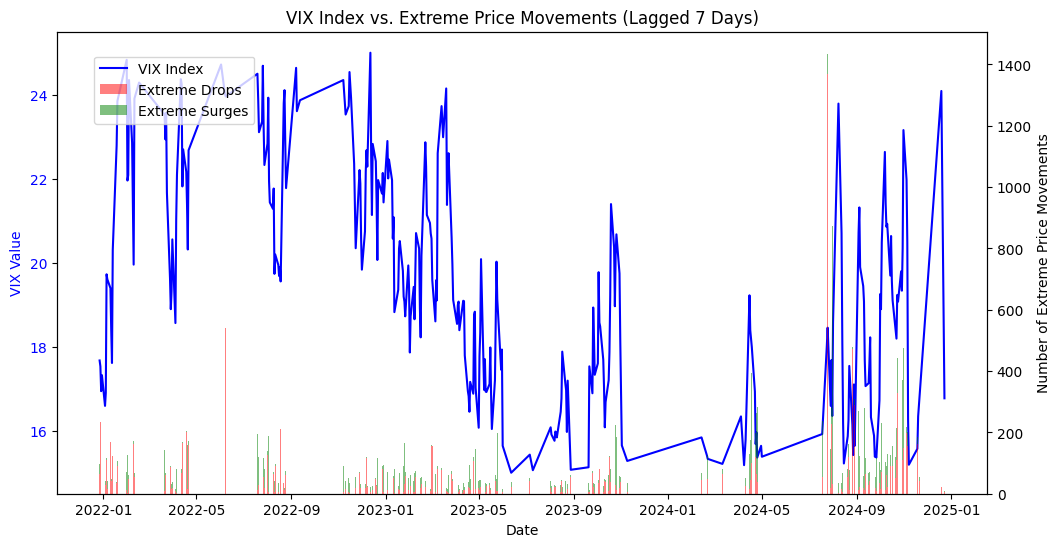

In [75]:
df['vix_date'] = pd.to_datetime(df['vix_date'])
df['drop_date'] = pd.to_datetime(df['drop_date'])

# filter by Moderate Volatility 
df = df[df['vix_category'] == 'Moderate Volatility']

# Plot VIX with Extreme Movements
fig, ax1 = plt.subplots(figsize=(12,6))

# VIX line (Left Y-axis)
ax1.plot(df['vix_date'], df['vix_value'], color='blue', label="VIX Index")
ax1.set_ylabel("VIX Value", color='blue')
ax1.set_xlabel("Date")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("VIX Index vs. Extreme Price Movements (Lagged 7 Days)")

# Secondary Y-axis for Extreme Drops and Surges
ax2 = ax1.twinx()
ax2.bar(df['vix_date'], df['num_drops'], color='red', alpha=0.5, label="Extreme Drops")
ax2.bar(df['vix_date'], df['num_surges'], color='green', alpha=0.5, label="Extreme Surges", bottom=df['num_drops'])
ax2.set_ylabel("Number of Extreme Price Movements")

# Legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.show()


Gotta zoom in to really see it, but VIX tends to increase and a few days after there is an extreme drop or surge 

So VIX spikes influence FUTURE movements

In [ ]:
df = con.execute(""" 
SELECT 
    v.vix_date, 
    v.vix_value, 
    e.trading_date,
    e.ticker,
    e.price_change_percentage,
    e.movement_type,
    CAST(e.trading_date - v.vix_date AS INTEGER) AS days_after_vix  
FROM SP500.VIX_Index v
JOIN Headlines.extreme_price_movements e  
    ON e.trading_date BETWEEN v.vix_date + INTERVAL '1 day' 
                         AND v.vix_date + INTERVAL '7 day'  
WHERE v.vix_value BETWEEN 15 AND 25  
ORDER BY v.vix_value DESC;
""").fetch_df()

movement_counts = df.groupby(['days_after_vix', 'movement_type']).size().reset_index(name='count')


In [71]:
df.head()

,vix_date,vix_value,trading_date,ticker,price_change_percentage,movement_type,days_after_vix
0,2022-12-12,25.0,2022-12-19,SMCI,6.41,Surge,7
1,2022-12-12,25.0,2022-12-19,RNA,5.91,Surge,7
2,2022-12-12,25.0,2022-12-19,AEL,7.00,Surge,7
3,2022-12-12,25.0,2022-12-19,RIG,6.71,Surge,7
4,2022-12-12,25.0,2022-12-19,UNG,-7.72,Drop,7


In [72]:
movement_counts.head()

,days_after_vix,movement_type,count
0,1,Drop,7467
1,1,Surge,7568
2,2,Drop,6383
3,2,Surge,6810
4,3,Drop,6191


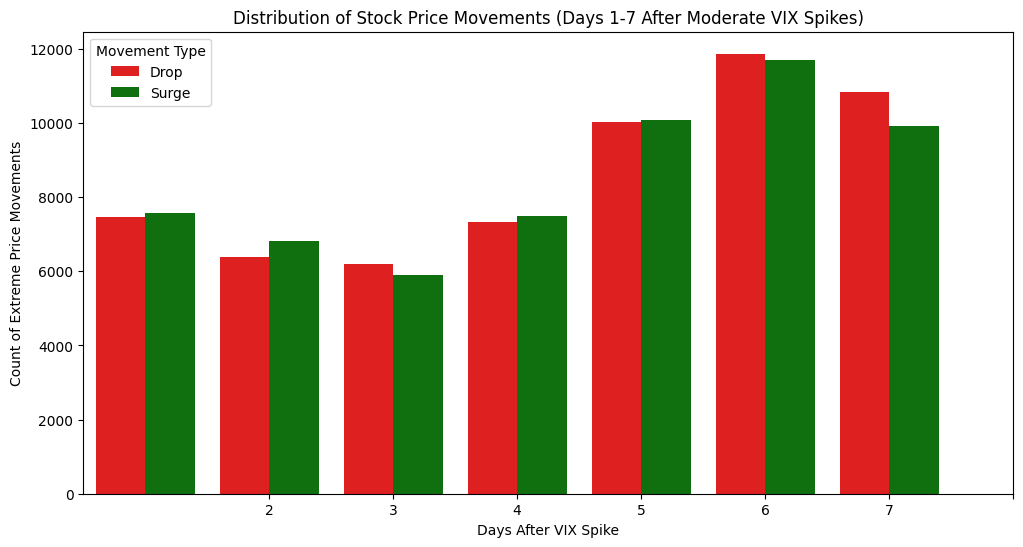

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=movement_counts, x='days_after_vix', y='count', hue='movement_type', palette={'Drop': 'red', 'Surge': 'green'})

# Labels and title
plt.xlabel("Days After VIX Spike")
plt.ylabel("Count of Extreme Price Movements")
plt.title("Distribution of Stock Price Movements (Days 1-7 After Moderate VIX Spikes)")
plt.legend(title="Movement Type")
plt.xticks(range(1, 8))  # Only show days 1-7

# Show plot
plt.show()


So looking at this we can see the timing of the extreme price movements 
- Historically, days 5-7 have the highest count of extreme movements 
    - great for our 7 day lag 
- Can think about how this VIX will affect risk score. how would this weigh volatility over time! 
    

In [23]:
stats_df = con.execute("""
SELECT 
    v.vix_category,
    e.movement_type,
    a.title_sentiment_label,
    a.description_sentiment_label,
    COUNT(*) AS count
FROM (SELECT *,
    CASE 
        WHEN vix_value < 15 THEN 'Low Volatility'
        WHEN vix_value BETWEEN 15 AND 25 THEN 'Moderate Volatility'
        WHEN vix_value BETWEEN 25 AND 30 THEN 'High Volatility'
        ELSE 'Extreme Volatility'
    END AS vix_category
    from SP500.VIX_Index) v
JOIN Headlines.extreme_price_movements e 
    ON e.trading_date = v.vix_date + INTERVAL '1 day'
LEFT JOIN Headlines.articles_extreme_drops a 
    ON e.trading_date = a.trading_date 
    AND e.ticker = a.ticker
WHERE a.title_sentiment_label IS NOT NULL 
   OR a.description_sentiment_label IS NOT NULL
GROUP BY v.vix_category, e.movement_type, a.title_sentiment_label, a.description_sentiment_label
ORDER BY v.vix_category DESC, COUNT(*) DESC;
""").fetch_df()

stats_df.head()

,vix_category,movement_type,title_sentiment_label,description_sentiment_label,count
0,Moderate Volatility,Surge,Neutral,Neutral,2345
1,Moderate Volatility,Drop,Neutral,Neutral,2028
2,Moderate Volatility,Surge,Positive,Positive,1381
3,Moderate Volatility,Drop,Positive,Positive,1144
4,Moderate Volatility,Surge,Neutral,Positive,1090
